In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from datetime import datetime
from alexnet import AlexNet
import matplotlib.pyplot as plt
from datagenerator import ImageDataGenerator

from glob import glob
from keras.preprocessing import image                  
from tqdm import tqdm

from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn import metrics

from scipy import interp
from itertools import cycle

import random
random.seed(8675309)

Using TensorFlow backend.


In [2]:
def getNamesList(min_faces_per_person):
    lfw_people = fetch_lfw_people(min_faces_per_person=min_faces_per_person)
    names_list = []
    for name in lfw_people.target_names:
        a = name.split(' ')
        newA = []
        for i in range(0,len(a)):
            newA.append(a[i])
            if (i != len(a)-1):
                newA.append('_')
        new_name = ''
        for i in range(0,len(newA)):
            new_name += newA[i]
        names_list.append(new_name)
    return names_list

In [3]:
def getLabels(train_data):
    human_files_train_labels = np.zeros([train_data.shape[0]], dtype=int)
    for i in range (0,train_data.shape[0]):
        #print(train_data[i])
        label = train_data[i].split('/')[1]
        human_files_train_labels[i] = human_files_dictionary[label]
    return human_files_train_labels

In [4]:
def convert_to_categorical(labels):
    y = np.zeros([labels.shape[0],len(human_files_names)])
    for i in range(0,labels.shape[0]):
        y[i][labels[i]] = 1
    return y

In [5]:
def getPersonName(index):
    for key in human_files_dictionary.keys():
         if (index == human_files_dictionary[key]):
                return key

In [6]:
def convert_to_categorical(label):
    y = np.zeros([len(human_files_dictionary)])
    y[label] = 1
    return y

In [7]:
min_faces_per_person = 70
names_list = getNamesList(min_faces_per_person)

In [8]:
human_files_data = []
human_files_names = []
for i in range (0,len(names_list)):
    #human_files = np.array(glob('lfw/'+names_list[i]+'/*'))
    human_files_data.append(glob('lfw/'+names_list[i]+'/*'))
    human_files_names.append('lfw/'+names_list[i])
human_files = []
for i in range(0,len(names_list)):
    data = human_files_data[i]
    for j in range(0,len(data)):
        human_files.append(data[j])
human_files = np.asarray(human_files)
random.shuffle(human_files)

In [9]:
human_files_dictionary = dict()
for i in range(0,len(human_files_names)):
    human_files_dictionary.update({human_files_names[i].split('/')[1] : i})

In [10]:
train_divider = 0.5
test_divider = 0.3
train_limit = np.rint(train_divider * human_files.shape[0]).astype(int)
test_limit = np.rint(test_divider * human_files.shape[0]).astype(int)
#print(train_limit)
#print(test_limit)
human_files_train = human_files[ : train_limit]
human_files_test = human_files[train_limit : test_limit+train_limit]
human_files_valid = human_files[test_limit+train_limit : ]

In [11]:
human_files_train_labels = getLabels(human_files_train)
human_files_test_labels = getLabels(human_files_test)
human_files_valid_labels = getLabels(human_files_valid)

In [12]:
human_files_test.shape[0]

386

In [13]:
file = open('train.txt','w')
for i in range(0,human_files_train.shape[0]):
    file.write(human_files_train[i]+' '+str(human_files_train_labels[i]))
    if i != human_files_train.shape[0]-1:
        file.write('\n')
file.close() 

file = open('test.txt','w')
for i in range(0,human_files_test.shape[0]):
    file.write(human_files_test[i]+' '+str(human_files_test_labels[i]))
    if i != human_files_test.shape[0]-1:
        file.write('\n')
file.close() 

file = open('valid.txt','w')
for i in range(0,human_files_valid.shape[0]):
    file.write(human_files_valid[i]+' '+str(human_files_valid_labels[i]))
    if i != human_files_valid.shape[0]-1:
        file.write('\n')
file.close() 

In [14]:
train_file = 'train.txt'
test_file = 'test.txt'
valid_file = 'valid.txt'

In [15]:
# Learning params
learning_rate = 0.0005
num_epochs = 50
batch_size = 15

In [16]:
# Network params
dropout_rate = 0.5
num_classes = len(human_files_dictionary)
train_layers = ['fc8', 'fc7']

In [17]:
x = tf.placeholder(tf.float32, [batch_size, 227, 227, 3])
y = tf.placeholder(tf.float32, [None, num_classes])
keep_prob = tf.placeholder(tf.float32)

In [18]:
# Initialize model
model = AlexNet(x, keep_prob, num_classes, train_layers)

#link variable to model output
score = model.fc8
pred = tf.nn.softmax(score,name='pred')

In [19]:
var_list = [v for v in tf.trainable_variables() if v.name.split('/')[0] in train_layers]

# Op for calculating the loss
with tf.name_scope("cross_ent"):
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = score, labels = y))

# Train op
with tf.name_scope("train"):
  # Get gradients of all trainable variables
  gradients = tf.gradients(loss, var_list)
  gradients = list(zip(gradients, var_list))
# Create optimizer and apply gradient descent to the trainable variables
  optimizer = tf.train.GradientDescentOptimizer(learning_rate)
  train_op = optimizer.apply_gradients(grads_and_vars=gradients)

# Add gradients to summary
for gradient, var in gradients:
  tf.summary.histogram(var.name + '/gradient', gradient)

# Add the variables we train to the summary
for var in var_list:
  tf.summary.histogram(var.name, var)

# Add the loss to summary
tf.summary.scalar('cross_entropy', loss)

INFO:tensorflow:Summary name fc7/weights:0/gradient is illegal; using fc7/weights_0/gradient instead.
INFO:tensorflow:Summary name fc7/biases:0/gradient is illegal; using fc7/biases_0/gradient instead.
INFO:tensorflow:Summary name fc8/weights:0/gradient is illegal; using fc8/weights_0/gradient instead.
INFO:tensorflow:Summary name fc8/biases:0/gradient is illegal; using fc8/biases_0/gradient instead.
INFO:tensorflow:Summary name fc7/weights:0 is illegal; using fc7/weights_0 instead.
INFO:tensorflow:Summary name fc7/biases:0 is illegal; using fc7/biases_0 instead.
INFO:tensorflow:Summary name fc8/weights:0 is illegal; using fc8/weights_0 instead.
INFO:tensorflow:Summary name fc8/biases:0 is illegal; using fc8/biases_0 instead.


<tf.Tensor 'cross_entropy:0' shape=() dtype=string>

In [20]:
# Evaluation op: Accuracy of the model
with tf.name_scope("accuracy"):
  correct_pred = tf.equal(tf.argmax(score, 1), tf.argmax(y, 1))
  accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Add the accuracy to the summary
tf.summary.scalar('accuracy', accuracy)

<tf.Tensor 'accuracy_1:0' shape=() dtype=string>

In [21]:
# Merge all summaries together
merged_summary = tf.summary.merge_all()

# Initialize an saver for store model checkpoints
saver = tf.train.Saver()

In [22]:
checkpoint_path = "/tmp/finetune_alexnet/"
if not os.path.isdir(checkpoint_path): os.mkdir(checkpoint_path)

In [23]:
train_generator = ImageDataGenerator(train_file,horizontal_flip = True, nb_classes = num_classes)
test_generator = ImageDataGenerator(test_file, nb_classes = num_classes)
valid_generator = ImageDataGenerator(valid_file, nb_classes = num_classes)

train_batches_per_epoch = np.floor(train_generator.data_size / batch_size).astype(np.int16)
test_batches_per_epoch = np.floor(test_generator.data_size / batch_size).astype(np.int16)
valid_batches_per_epoch = np.floor(valid_generator.data_size / batch_size).astype(np.int16)

In [24]:
with tf.Session() as sess:

  # Initialize all variables
  sess.run(tf.global_variables_initializer())

  # Load the pretrained weights into the non-trainable layer
  model.load_initial_weights(sess)
    
  for i in range(0,1):
    for epoch in range(num_epochs):
        print("{} Epoch number: {}".format(datetime.now(), epoch+1))
        step = 1
        while step < train_batches_per_epoch:
            # Get a batch of images and labels
            batch_xs, batch_ys = train_generator.next_batch(batch_size)
            # And run the training op
            sess.run(train_op, feed_dict={x: batch_xs,
                                          y: batch_ys,
                                          keep_prob: dropout_rate})
            # Generate summary with the current batch of data and write to file
            if step%1 == 0:
                s = sess.run(merged_summary, feed_dict={x: batch_xs,
                                                        y: batch_ys,
                                                        keep_prob: 1.})
            step += 1
        # validate the model on the entire validation set
        print("{} Start validation".format(datetime.now()))
        valid_acc = 0.
        valid_count = 0
        classification_pred_data = []
        classification_actual_data = []
        for n_c in range(valid_batches_per_epoch):
            batch_tx, batch_ty = valid_generator.next_batch(batch_size)
            acc = sess.run(accuracy, feed_dict={x: batch_tx,
                                                y: batch_ty,
                                                keep_prob: 1.})
            valid_acc += acc
            valid_count += 1
        valid_acc /= valid_count
        print("valid accuracy:")
        print(valid_acc)

        # Reset the file pointer of the image data generator
        valid_generator.reset_pointer()
        train_generator.reset_pointer()
    # Calculate Test Accuracy
    prediction_list = []
    y_list = []
    test_acc_sum = 0
    valid_count = 0
    for _ in range(test_batches_per_epoch):
        test_batch_x, test_batch_y = test_generator.next_batch(batch_size)
        y_list.append(test_batch_y)
        prediction=tf.argmax(test_batch_y,1)
        test_acc = sess.run(accuracy, feed_dict={
            x: test_batch_x,
            y: test_batch_y,
            keep_prob: 1.})
        pred = prediction.eval(feed_dict={x: test_batch_x})
        prediction_list.append(pred)
        valid_count += 1
        test_acc_sum += test_acc
    #print('Prediction: {}'.format(pred))
    print('Testing Accuracy: {}'.format(test_acc_sum/valid_count))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/siddhant/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-24-ecde61ee785c>", line 7, in <module>
    model.load_initial_weights(sess)
  File "/Users/siddhant/Downloads/siddhant/RU/Deep Learning Final Project/alexnet.py", line 111, in load_initial_weights
    session.run(var.assign(data))
  File "/Users/siddhant/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 551, in assign
    return state_ops.assign(self._variable, value, use_locking=use_locking)
  File "/Users/siddhant/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_state_ops.py", line 47, in assign
    use_locking=use_locking, name=name)
  File "/Users/siddhant/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 491, in apply_op
    preferred_dtype=default_dtype)
  File "/User

KeyboardInterrupt: 

In [25]:
# Compute ROC curve and ROC area for each class
output_size = len(y_list)
fpr = dict()
tpr = dict()
roc_auc = dict()
count = 0
for i in range(output_size):
    for j in range(num_classes):
        fpr[count], tpr[count], _ = roc_curve(y_list[i][j],convert_to_categorical(prediction_list[i][j]))
        roc_auc[count] = auc(fpr[count], tpr[count])
        count += 1

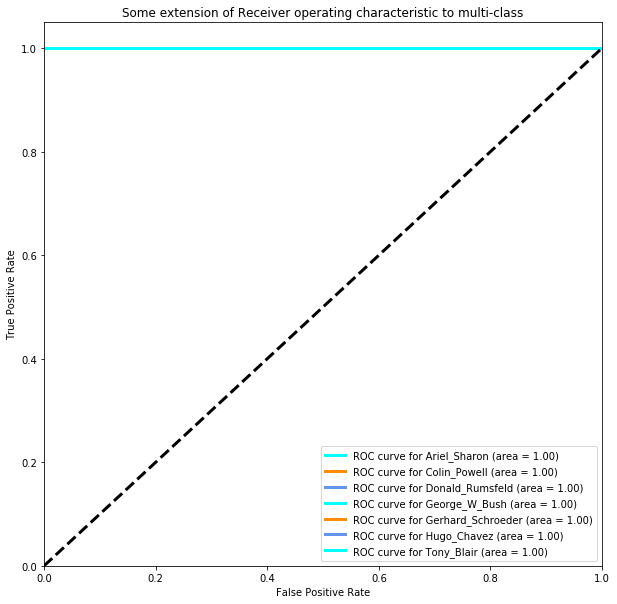

In [26]:
line_width = 3
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(output_size)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(output_size):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= output_size

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10, 10))

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=line_width,
             label='ROC curve for '+getPersonName(i)+' (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=line_width)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()